<a href="https://colab.research.google.com/github/tanishkabishtt/food-delivery-churn/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn matplotlib


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Number of customers
n_customers = 500

# Generate synthetic dataset
df = pd.DataFrame({
    "CustomerID": range(1, n_customers+1),
    "OrderFrequency": np.random.randint(0, 10, n_customers),  # orders per month
    "LastOrder": [datetime.today() - timedelta(days=np.random.randint(1, 180)) for _ in range(n_customers)],
    "Rating": np.random.randint(1, 6, n_customers),  # 1 to 5 stars
    "Complaints": np.random.randint(0, 4, n_customers)  # number of complaints
})

df.head()


,CustomerID,OrderFrequency,LastOrder,Rating,Complaints
0,1,6,2025-08-03 14:40:31.338098,3,1
1,2,3,2025-10-17 14:40:31.338138,3,2
2,3,7,2025-10-30 14:40:31.338152,3,3
3,4,4,2025-07-26 14:40:31.338162,3,3
4,5,6,2025-09-15 14:40:31.338172,2,1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline


In [5]:
df['LastOrder'] = pd.to_datetime(df['LastOrder'], errors='coerce')
df['OrderFrequency'] = pd.to_numeric(df['OrderFrequency'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Complaints'] = pd.to_numeric(df['Complaints'], errors='coerce')

df['OrderFrequency'] = df['OrderFrequency'].fillna(0)
df['Rating'] = df['Rating'].fillna(df['Rating'].median())
df['Complaints'] = df['Complaints'].fillna(0)
df['LastOrder'] = df['LastOrder'].fillna(df['LastOrder'].min())


In [6]:
today = pd.Timestamp.today().normalize()
df['DaysSinceLastOrder'] = (today - df['LastOrder']).dt.days.clip(lower=0)
df['AvgOrderGapDays'] = np.where(df['OrderFrequency'] > 0, 30 / df['OrderFrequency'], 365)

df['EngagementScore'] = (
    0.5 * df['Rating'] +
    0.4 * df['OrderFrequency'] -
    0.3 * df['Complaints']
)

df['RatingNorm'] = (df['Rating'] - df['Rating'].min()) / (df['Rating'].max() - df['Rating'].min() + 1e-9)

# Define churn: no order in > 60 days OR low engagement
CHURN_RECENCY_DAYS = 60
ENGAGEMENT_LOW = df['EngagementScore'].quantile(0.25)

df['Churn'] = np.where(
    (df['DaysSinceLastOrder'] > CHURN_RECENCY_DAYS) | (df['EngagementScore'] < ENGAGEMENT_LOW),
    1, 0
)

df.head()


,CustomerID,OrderFrequency,LastOrder,Rating,Complaints,DaysSinceLastOrder,AvgOrderGapDays,EngagementScore,RatingNorm,Churn
0,1,6,2025-08-03 14:40:31.338098,3,1,104,5.000000,3.6,0.50,1
1,2,3,2025-10-17 14:40:31.338138,3,2,29,10.000000,2.1,0.50,0
2,3,7,2025-10-30 14:40:31.338152,3,3,16,4.285714,3.4,0.50,0
3,4,4,2025-07-26 14:40:31.338162,3,3,112,7.500000,2.2,0.50,1
4,5,6,2025-09-15 14:40:31.338172,2,1,61,5.000000,3.1,0.25,1


              precision    recall  f1-score   support

           0       0.70      0.97      0.82        32
           1       0.99      0.86      0.92        93

    accuracy                           0.89       125
   macro avg       0.85      0.91      0.87       125
weighted avg       0.92      0.89      0.89       125

ROC AUC: 0.95127688172043


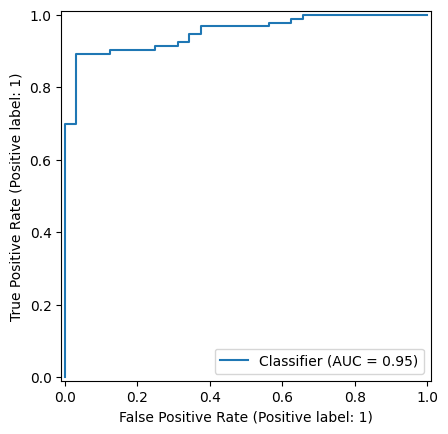

In [7]:
features = ['DaysSinceLastOrder','AvgOrderGapDays','OrderFrequency','Rating','Complaints','EngagementScore','RatingNorm']
X = df[features]
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()


In [8]:
df['ChurnRiskProb'] = pipe.predict_proba(X)[:,1]
df['RiskTier'] = pd.cut(df['ChurnRiskProb'], bins=[-0.01,0.33,0.66,1.01], labels=['Low','Medium','High'])

def recommend_action(row):
    if row['RiskTier'] == 'High':
        return "Win-back offer: 30% off + free delivery"
    elif row['RiskTier'] == 'Medium':
        return "Reminder: 15% off weekend orders"
    else:
        return "Loyalty rewards: early access to festival offers"

df['RetentionOffer'] = df.apply(recommend_action, axis=1)

df[['CustomerID','ChurnRiskProb','RiskTier','RetentionOffer']].head(10)


,CustomerID,ChurnRiskProb,RiskTier,RetentionOffer
0,1,0.946704,High,Win-back offer: 30% off + free delivery
1,2,0.095959,Low,Loyalty rewards: early access to festival offers
2,3,0.019586,Low,Loyalty rewards: early access to festival offers
3,4,0.983189,High,Win-back offer: 30% off + free delivery
4,5,0.478738,Medium,Reminder: 15% off weekend orders
5,6,0.632581,Medium,Reminder: 15% off weekend orders
6,7,0.973439,High,Win-back offer: 30% off + free delivery
7,8,0.884348,High,Win-back offer: 30% off + free delivery
8,9,0.993422,High,Win-back offer: 30% off + free delivery
9,10,0.029567,Low,Loyalty rewards: early access to festival offers


In [9]:
df[['CustomerID','ChurnRiskProb','RiskTier','RetentionOffer']].to_csv("churn_recommendations.csv", index=False)

from google.colab import files
files.download("churn_recommendations.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>